In [1]:
!git clone https://github.com/ymzhu19eee/dataset_microplastics


Cloning into 'dataset_microplastics'...
remote: Enumerating objects: 780, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 780 (delta 11), reused 5 (delta 1), pack-reused 742
Receiving objects: 100% (780/780), 103.20 MiB | 30.03 MiB/s, done.
Resolving deltas: 100% (13/13), done.
Updating files: 100% (721/721), done.


In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# First, install the library using pip
!pip install split-folders

# Then, import the library
import splitfolders

# Specify the path to your dataset and the output directory
input_folder = 'dataset_microplastics/micro_plastic'
output_folder = 'dataset_microplastics/Train_test'

# Use the ratio function to split the data
# This will split the dataset into training and test sets with 80% and 20% of the data respectively
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .2))


Copying files: 719 files [00:00, 3215.66 files/s]


In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
training_set = train_datagen.flow_from_directory('dataset_microplastics/Train_test/train',
                                                 target_size=(64,64),
                                                 batch_size=32,
                                                 class_mode='sparse')

Found 571 images belonging to 9 classes.


In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory('dataset_microplastics/Train_test/val',
                                                 target_size=(64,64),
                                                 batch_size=32,
                                                 class_mode='sparse')

Found 148 images belonging to 9 classes.


In [6]:
from tensorflow import keras

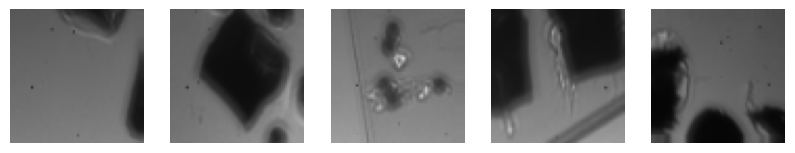

In [7]:
import matplotlib.pyplot as plt
# Get a batch of images
images, labels = next(training_set)

# Define number of images to show
num_images = 5

# Plot the images
plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i])
    plt.axis('off')
plt.show()


Based on the current page content, here are some ideas to improve the accuracy of your machine learning model:

- **Data Augmentation**: You're already using techniques like shear, zoom, and horizontal flip. Consider adding more variations such as rotation, width and height shift, and brightness change to make your model more robust to different conditions.

- **Hyperparameter Tuning**: Utilize the RandomSearch tuner to explore a wider range of hyperparameters. You can also try other optimization algorithms like Bayesian Optimization or Genetic Algorithms for potentially better results.

- **Model Architecture**: Experiment with different architectures, adding more convolutional layers, or trying pre-trained models like VGG16, ResNet, or Inception for transfer learning.

- **Regularization**: To prevent overfitting, consider using dropout layers or L1/L2 regularization in your dense layers.

Improving model accuracy is an iterative process and requires experimentation with different techniques.

In [8]:
#Hyperparameter tuning to get best parameters
def build_model(hp):
  model = keras.Sequential()
  #Constructing a common architecture of CNN
  model.add(keras.layers.Conv2D(filters = hp.Int('conv_1_filters',min_value=16, max_value = 128, step = 16),
                                kernel_size=hp.Choice('kernel1_size',values=[3,5,7]),
                                input_shape=(64,64,3),
                                activation='relu',groups=1))
  model.add(keras.layers.MaxPool2D(pool_size = hp.Int('pool_1_size',min_value=2,max_value=8,step=1),
                                   strides=hp.Choice('strides_1',values=[1,2,3])))


  model.add(keras.layers.Conv2D(filters = hp.Int('conv_2_filters',min_value=16, max_value = 128, step = 16),
                                kernel_size=hp.Choice('kernel2_size',values=[3,5,7]),
                                activation='relu',groups=1))
  model.add(keras.layers.MaxPool2D(pool_size = hp.Int('pool_2_size',min_value=2,max_value=8,step=1),
                                   strides=hp.Choice('strides_2',values=[1,2,3])))

  model.add(keras.layers.Flatten())


  model.add(keras.layers.Dense(units=hp.Int('dense_1_layer',min_value=16,max_value=256,step=16),
                               activation='relu'))
  model.add(keras.layers.Dense(units=9,activation='sigmoid'))

  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate',values=[1e-2,1e-3])),
                                                loss='sparse_categorical_crossentropy',
                                                metrics=['accuracy'])
  return model

In [9]:
!pip install keras-tuner
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

tunersearch = RandomSearch(build_model,objective='val_accuracy',max_consecutive_failed_trials=3,
                           max_trials=5,directory='output',project_name='Microplastic_')

tunersearch.search(training_set,
                   epochs=7,
                   validation_data=test_set)

Trial 5 Complete [00h 02m 04s]
val_accuracy: 0.5337837934494019

Best val_accuracy So Far: 0.6554054021835327
Total elapsed time: 00h 10m 05s


In [10]:
model = tunersearch.get_best_models(num_models=1)[0]
model.summary()
# This is the model with best accuracy among the 5 trials.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 61, 61, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 55, 55, 16)        12560     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 17, 17, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4624)              0         
                                                                 
 dense (Dense)               (None, 128)               5

In [11]:
#Since the accuracy in the previous model is very low, differet architecture of CNN is trained
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model

# Using vgg16 architecture

vgg = VGG16(input_shape=[224,224,3],weights = 'imagenet', include_top=False)

# Fixing vgg model layers to prevent them from losing the weights from pre-trained model
for i in vgg.layers:
  i.trainable = False
#Adding our own layers
x = GlobalAveragePooling2D()(vgg.output)
x = Dense(units = 500, activation='relu')(x)
x = Dense(units=9, activation='sigmoid')(x)
model2 = Model(inputs = vgg.input, outputs = x)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#VGG16 expects input in [224,224,3] format
training_set = train_datagen.flow_from_directory('dataset_microplastics/Train_test/train',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')
test_set = test_datagen.flow_from_directory('dataset_microplastics/Train_test/val',
                                                 target_size=(224,224),
                                                 batch_size=32,
                                                 class_mode='categorical')

model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model2.fit(training_set,validation_data=test_set,epochs=30)

58889256/58889256 [==============================] - 0s 0us/step
Found 571 images belonging to 9 classes.
Found 148 images belonging to 9 classes.
Epoch 1/30
18/18 [==============================] - 37s 2s/step - loss: 1.9793 - accuracy: 0.3030 - val_loss: 1.7819 - val_accuracy: 0.4122
Epoch 2/30
18/18 [==============================] - 21s 1s/step - loss: 1.7259 - accuracy: 0.3713 - val_loss: 1.5618 - val_accuracy: 0.4324
Epoch 3/30
18/18 [==============================] - 23s 1s/step - loss: 1.5789 - accuracy: 0.4483 - val_loss: 1.4053 - val_accuracy: 0.5068
Epoch 4/30
18/18 [==============================] - 22s 1s/step - loss: 1.4160 - accuracy: 0.5464 - val_loss: 1.3073 - val_accuracy: 0.6014
Epoch 5/30
18/18 [==============================] - 23s 1s/step - loss: 1.3068 - accuracy: 0.6112 - val_loss: 1.1522 - val_accuracy: 0.6554
Epoch 6/30
18/18 [==============================] - 22s 1s/step - loss: 1.1981 - accuracy: 0.6708 - val_loss: 1.0795 - val_accuracy: 0.7365
Epoch 7/30
18

In [12]:
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
model2.save('final_microplastic')

Plotting change in loss in training

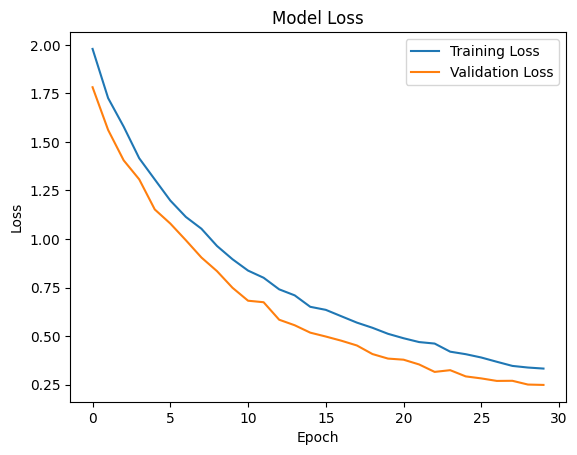

In [14]:
import matplotlib.pyplot as plt

# Assuming 'model2.history' contains the history callback from your training process
plt.plot(model2.history.history['loss'], label='Training Loss')
plt.plot(model2.history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()


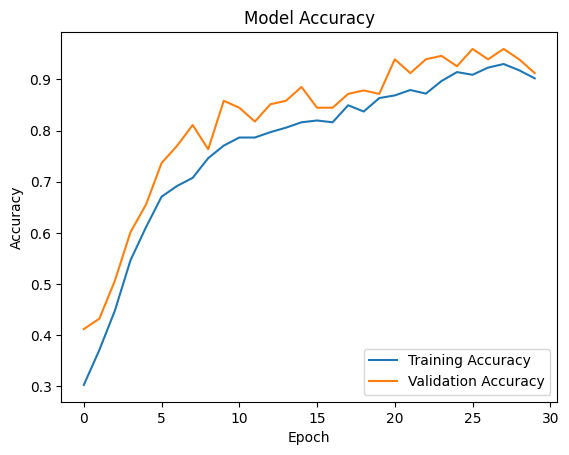

In [15]:
# Assuming 'model2.history' contains the history callback from your training process
plt.plot(model2.history.history['accuracy'], label='Training Accuracy')
plt.plot(model2.history.history['val_accuracy'], label='Validation Accuracy')

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.show()


In [16]:
'''
# For testing custom image
import numpy as np
from keras.applications.vgg16 import decode_predictions
from keras.preprocessing import image
test_image = image.load_img('path', target_size = (224, 224))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = model2.predict(test_image)
# decoding top 3 predictions:
print('Predicted:', decode_predictions(preds, top=3)[0])'''


"\n# For testing custom image\nimport numpy as np\nfrom keras.applications.vgg16 import decode_predictions\nfrom keras.preprocessing import image\ntest_image = image.load_img('path', target_size = (224, 224))\ntest_image = image.img_to_array(test_image)\ntest_image = np.expand_dims(test_image, axis = 0)\nresult = model2.predict(test_image)\n# decoding top 3 predictions:\nprint('Predicted:', decode_predictions(preds, top=3)[0])"